This notebook is part of the [Machine Learning class](https://github.com/erachelson/MLclass) by [Emmanuel Rachelson](https://personnel.isae-supaero.fr/emmanuel-rachelson?lang=en).

License: CC-BY-SA-NC.

<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Support Vector Machines,<br> the Bias-Variance tradeoff<br> and a short introduction to kernel theory</div>

1. [A geometrical approach to Machine Learning: margin maximization](#sec1)
    1. [The notion of margin](#sec1-1)
    2. [Optimal separating hyperplanes](#sec1-2)
    3. [Support vectors and sparsity](#sec1-3)
    4. [The non-linearly separable case](#sec1-4)
    5. [Making predictions](#sec1-5)
2. [Support Vector Machines in scikit-learn](#sec2)
3. [When using linear separators makes no more sense](#sec3)
4. [A word on the bias-variance tradeoff](#sec4)
5. [The kernel trick](#sec5)
    1. [The intuition of mapping to higher dimensions](#sec5-1)
    2. [The kernel trick](#sec5-2)
    3. [Positive definite kernels](#sec5-3)
6. [SVMs and kernels](#sec6)
7. [What about other uses?](#sec7)
8. [Examples](#sec8)
    1. [Spam or ham?](#sec8-1)
    2. [NIST](#sec8-2)

<div class="alert alert-success"><b>In a nutshell:</b>
<ul>
<li> Support Vector Machines try to separate data by maximizing a geometrical margin
<li> They are computed offline
<li> They offer a sparse, robust to class imbalance, and easy to evaluate predictor
<li> Kernels are a way of enriching (lifting) the data representation so that it becomes linearly separable
<li> SVMs + kernels offer a versatile method for classification, regression and density estimation
<li> [Documentation in scikit-learn](http://scikit-learn.org/stable/modules/svm.html)
</ul>
</div>

# <a id="sec1"></a> 1. A geometrical approach to Machine Learning

## <a id="sec1-1"></a> 1.1 The notion of margin

Suppose we are given the dataset $\{(x_i,y_i)\}$ below.

(900, 3)
(900, 2)
(900,)


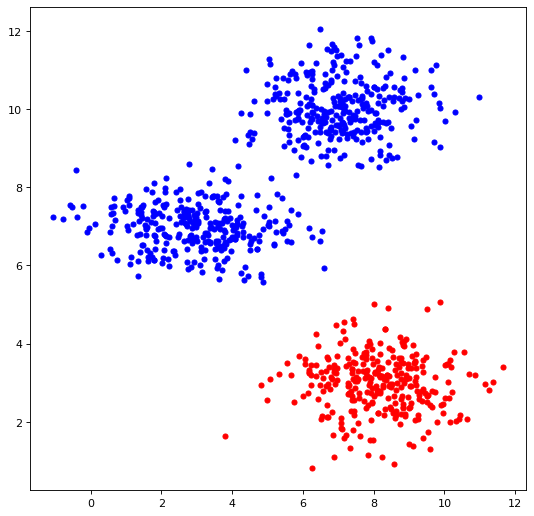

In [1]:
import numpy as np
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
fig_size=(8, 8)

res = np.loadtxt("sep_lin.csv", delimiter=',')
print(res.shape)
X = res[:,0:-1]
y = res[:,-1].astype(int)
print(X.shape)
print(y.shape)
Xblue = X[y==-1]
Xred = X[y==1]

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20);

<div class="alert alert-warning"><b>Question (collective answer)</b><br>
<ul>
<li> What constitutes a "good" separating line between red and blue dots?
<li> What about the lines below?
</ul>
</div>

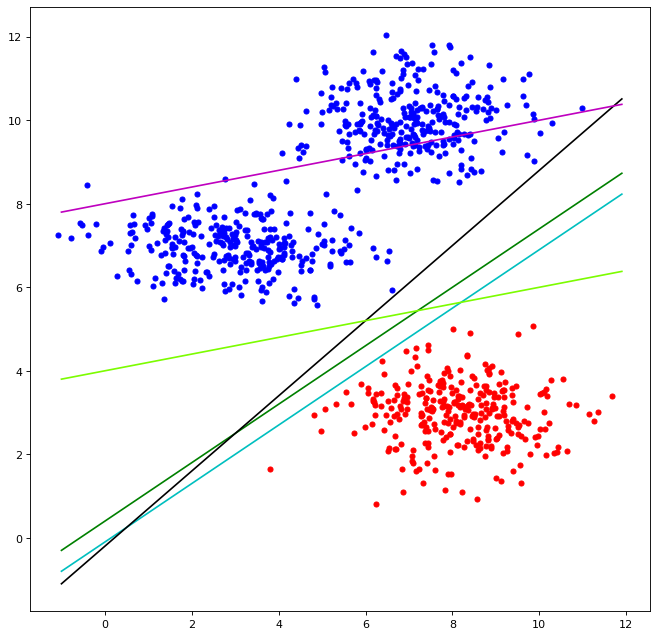

In [5]:
fig_size=(10,10)
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = 0.7*XX+0.4
plt.plot(XX,YY,c='g')
YY = 0.7*XX-0.1
plt.plot(XX,YY,c='c')
YY = 0.9*XX-0.2
plt.plot(XX,YY,c='k')
YY = 0.2*XX+4
plt.plot(XX,YY,c='lawngreen')
YY = 0.2*XX+8
plt.plot(XX,YY,c='m');

The best separating hyperplane is the one that maximizes the distance to the closest points.

<div class="alert alert-warning"><b>Question</b><br>
Suppose $w$ is the hyperplane's normal vector, $w_0$ is its intercept, and $\|w\|=1$. What is the expression of this distance?
</div>

<div class="alert alert-danger"><a href="#answer1" data-toggle="collapse"><b>Ready to see the answer? (click to expand)</b></a><br>
<div id="answer1" class="collapse">

Let's write $M$ this distance and call it **the margin**.

$$M = \min_i y_i(w^Tx_i + w_0)$$
</div>
</div>

<div class="alert alert-warning"><b>Question</b><br>
What is the margin of the dark green line in the example above?
</div>
To answer this question, recall that given a hyperplane of equation $w^Tx + w_0=0$, with $\|w\|=1$, the (signed) distance between $x_i$ and the hyperplane is precisely $w^Tx_i + w_0$.

In [10]:
# %load solutions/code1.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

w = np.array([0.7, -1])
w = w/np.linalg.norm(w)
print(w)
w0 = 0.4/np.linalg.norm(w)
print(w0)
M = y*(np.dot(X,w) + w0)
#print(M)
print("margin =", np.min(M))


[ 0.57346234 -0.81923192]
0.4
margin = 0.5823203757923597


## <a id="sec1-2"></a> 1.2 Optimal separating hyperplanes

We want to find the hyperplane that maximizes the margin, so:
$$\max_{M,w,w_0} M$$
$$y_i(w^Tx_i + w_0) \geq M, \forall i \in [1,N]$$
$$\|w\| = 1$$
Let's use some optimization routines for that.

<div class="alert alert-warning">
    
**Exercice**<br>
The `fmin_slsqp` function from `scipy.optimize` solves constrained non-linear optimization problems by sequential least squares programming. It takes as inputs:
<ul>
<li> a function `func` of variable vector `x`,
<li> an initial guess `x0` for `x`,
<li> a function `eq_const` that returns a vector of values corresponding to the equality constraints `eq_const(x)==0`,
<li> a function `ineq_const` that returns a vector of values corresponding to the inequality constraints `ineq_const(x)>=0`.
</ul>
</div>

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.7226638108576711
            Iterations: 7
            Function evaluations: 35
            Gradient evaluations: 7
[ 0.72266381  0.42124178 -0.90694838  1.88363065]
margin = 0.7226638108576711


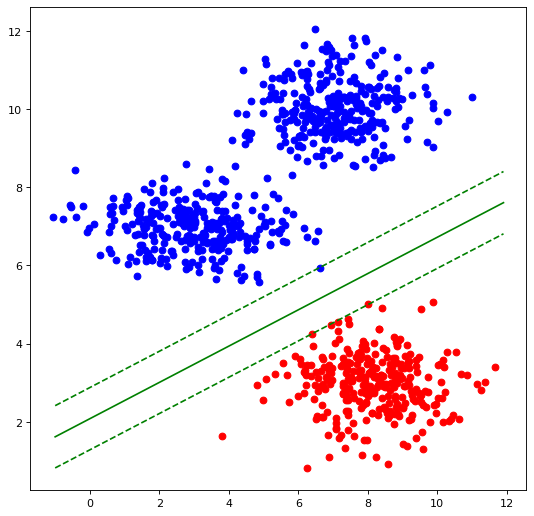

In [2]:
# %load solutions/code2.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

import scipy.optimize as sopt

def func(x):
    """x = (M,w_1,w_2,b)"""
    return -x[0]        #valeur a miniminser

def ineq_constr(x):
    """x = (M,w_1,w_2,b)"""   #inegalité a respecter
    return y*(x[1]*X[:,0] + x[2]*X[:,1] + x[3]*np.ones(X.shape[0])) - x[0]*np.ones(X.shape[0])   

def eq_const(x):
    return x[1]*x[1]+x[2]*x[2]-1 # egalités a respecter

x0 = np.array([0.,0.7,-1.,0.4])
res = sopt.fmin_slsqp(func, x0, f_eqcons=eq_const, f_ieqcons=ineq_constr)
print(res)
print("margin =", res[0])
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[3])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[3]+res[0])/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[3]-res[0])/res[2]
plt.plot(XX,YY,'g--');



We can simplify the optimization problem above.

<div class="alert alert-warning">
    
**Exercice:**<br>
Use the variable change $w' = \frac{w}{M}$ and $w'_0 = \frac{w_0}{M}$ to get rid of $M$ in the optimization problem above.
</div>

<div class="alert alert-danger"><a href="#answer2" data-toggle="collapse">

**Ready to see the answer? (click to expand)**</a><br>
<div id="answer2" class="collapse">
We have $w=M w'$ and $w_0 = M w'_0$, so the problem becomes:
$$\max_{M,w',w'_0} M$$
$$y_i(M w'^Tx_i + M w'_0) \geq M, \forall i \in [1,N]$$
$$\|M w'\| = 1$$
And more simply:
$$\max_{M,w',w'_0} M$$
$$y_i(w'^Tx_i + w'_0) \geq 1, \forall i \in [1,N]$$
$$M = \frac{1}{\|w'\|}$$
And finally, by noting that $\arg\max \frac{1}{\|w'\|} = \arg\min \|w'\|$:
$$\min_{w',w'_0} \frac{1}{2}\|w'\|^2$$
$$y_i (w'^T x_i + w'_0) \geq 1, \forall i \in [1,N]$$
Let's just rename $w'$ into $w$ and $w'_0$ into $w_0$:
$$\min_{w,w_0} \frac{1}{2}\|w\|^2$$
$$y_i (w^T x_i + w_0) \geq 1, \forall i \in [1,N]$$
</div>
</div>

Let's check we obtain the same result.

In [2]:
def func(w):
    """w=(w_0,w_1,w_2)"""
    return .5*(w[1]**2 + w[2]**2)  # a quoi sert le .5 ?

def ineq_constr(w):
    """w=(w_0,w_1,w_2)"""
    return y*(w[1]*X[:,0] + w[2]*X[:,1] + w[0]*np.ones(X.shape[0])) - np.ones(X.shape[0])

x0 = np.array([0.4,0.7,-1.])
res = sopt.fmin_slsqp(func, x0, f_ieqcons=ineq_constr)
print(res)
M = 1. # and not anymore M = 1. / np.linalg.norm(np.array([res[1],res[2]]))
print("margin =", M)
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r')
XX = np.arange(-1.,12.,0.1)
YY = -(res[1]*XX+res[0])/res[2]
plt.plot(XX,YY,c='g')
YY = -(res[1]*XX+res[0]+M)/res[2]
plt.plot(XX,YY,'g--')
YY = -(res[1]*XX+res[0]-M)/res[2]
plt.plot(XX,YY,'g--');

NameError: name 'sopt' is not defined

## <a id="sec1-3"></a> 1.3 Support Vectors and sparsity

This is a quadratic programming problem. Let's try to solve it analytically.

We can introduce the Lagrange multipliers $\alpha_i$. Then the Lagrangian of the problem is:
$$L(w,w_0,\alpha) = \frac{1}{2}\|w\|^2 - \sum\limits_{i=1}^N \alpha_i\left(y_i\left(w^T x_i + w_0 \right)-1\right)$$

The solution must respect the first order Karush-Kuhn-Tucker conditions:
$$\left\{ \begin{array}{l}
\frac{\partial L}{\partial w} = 0 \Rightarrow w = \sum\limits_{i=1}^N \alpha_i y_i x_i\\
\frac{\partial L}{\partial w_0} = 0 \Rightarrow 0 = \sum\limits_{i=1}^N \alpha_i y_i\\
\forall i=1..N, \ \alpha_i\left(y_i\left(w^T x_i + w_0 \right)-1\right) = 0\\
\forall i=1..N, \alpha_i\geq 0
\end{array}\right.$$

Let's remark two things:
1. $w = \sum\limits_{i=1}^N \alpha_i y_i x_i$, so $w$ is a linear combination of the $x_i$
2. $\alpha_i\left(y_i\left(w^T x_i + w_0 \right)-1\right) = 0$ so at least one of the elements in this product is zero.

So we have two possibilities:
- $\alpha_i>0$, then $y_i\left(w^T x_i + w_0 \right)=1$; $x_i$ is on the margin's boundary
- $\alpha_i=0$, then $x_i$ is anywhere on the boundary or further... but does not participate in $w$.

Finding the optimal $\alpha_i$? That requires solving the dual problem (obtained by replacing $w$ in the Lagrangian above):
$$\max\limits_{\alpha\in{\mathbb{R}^+}^N} L_D(\alpha) = \sum\limits_{i=1}^N \alpha_i - \frac{1}{2}\sum\limits_{i=1}^N\sum\limits_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^T x_j\\\text{such that } \sum\limits_{i=1}^N \alpha_i y_i = 0$$

This dual problem is usually solved by a dedicated algorithm called SMO (John Platt (1998), Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines).

Once $\alpha$ is found, $w=\sum\limits_{i=1}^N \alpha_i y_i x_i$ follows, and <a href="#sidenote" data-toggle="collapse"> computing $w_0$ is almost trivial (click to see how).</a><br>
<div id="sidenote" class="collapse">
We have seen how to compute $w$ but what about $w_0$? Take any support vector $x_i$, its $\alpha_i$ is non-zero, so $y_i\left(w^T x_i + w_0 \right)=1$, so $w_0 = y_i-w^Tx_i$. In practice, to avoid numerical errors, one often averages over all support vectors with:
$$w_0 = \frac{\sum\limits_{i \ st. \ \alpha_i\neq 0} y_i-w^Tx_i}{\sum\limits_{i \ st. \ \alpha_i\neq 0} 1}$$
</div>

<div class="alert alert-success">

**Overall:**<br>
$$w = \sum\limits_{i=1}^N \alpha_i y_i x_i$$
The $x_i$ for which $\alpha_i>0$ are called **Support Vectors**. They lay on the margin's boundary.
</div>

In the end, the optimal separating hyperplane's normal vector is defined as a linear combination of the support vectors' coordinates. This linear combination is **sparse**, it has few non-zero coefficients.

That's it, we've built our first SVM!

## <a id="sec1-4"></a> 1.4 The non-linearly separable case

Ok, that's all very nice, but what if it is not possible to separate the data with a line, just as in the example below?

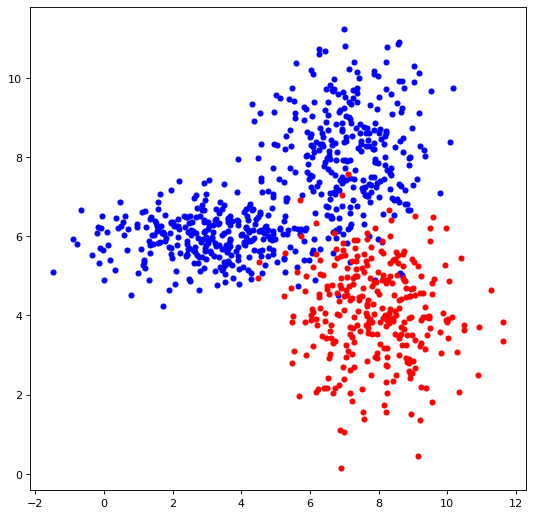

In [3]:
from sklearn import datasets
from sklearn.utils import shuffle

X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
#print(y1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
#print(y2)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)#, edgecolors='k')
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20);

We still would like to fit a line through the data, since we can assume the overlapping of the red and blue dots is due to noise. In this case, the optimal separating hyperplane can be found by making a **compromise** between the amount of misclassifications and the value of the margin.

For each pair $(x_i,y_i)$, we introduce the slack variable $\xi_i$ that represents how far $x_i$ is on the wrong side of the margin's boundary, as illustrated by the figure below.

<img width="300px" src="img/non_lin_sep3.png">

<div class="alert alert-warning">
    
**Exercice:**<br>
Let's write $y_i(w^T x_i + w_0) \geq M(1-\xi_i)$ and note that $x_i$ is misclassified if $\xi_i\geq1$.
Reformulate the SVM optimization problem so that we have a maximum of $K$ misclassifications.
</div>

<div class="alert alert-danger"><a href="#answer3" data-toggle="collapse">
    
**Ready to see the answer? (click to expand)**</a><br>
<div id="answer3" class="collapse">
The problem simply turns into:
$$\min_{w,w_0} \frac{1}{2}\|w\|^2$$
$$y_i (w^T x_i + w_0) \geq 1-\xi_i, \forall i \in [1,N]$$
$$\xi_i \geq 0$$
$$\sum\limits_{i=1}^N \xi_i \leq K$$
</div>
</div>

This last formulation with $K$ is not satisfying: instead of having to impose a constraint on the number of misclassifications, we would rather make a compromise between the number of misclassifications and the value of the margin. So the optimization problem turns into:
\begin{equation*}
\begin{array}{c}
\min\limits_{w,w_0,\xi} \displaystyle\frac{1}{2}\|w\|^2 + C\sum\limits_{i=1}^N \xi_i\\
\text{ such that } \forall i=1..N, \left\{\begin{array}{l}
y_i\left(w^T x_i + w_0 \right)\geq 1-\xi_i, \\
\xi_i\geq 0
\end{array}\right.
\end{array}
\end{equation*}

Note that $C$ is the parameter that controls the trade-off between having a large margin and having few misclassified points.

This is again a quadratic programming problem. Using the $\alpha_i$ and $\mu_i$ Lagrange multipliers, the KKT conditions yield:
\begin{gather*}
L_P = \frac{1}{2}\|w\|^2 + C\sum\limits_{i=1}^N \xi_i - \sum\limits_{i=1}^N \alpha_i\left(y_i\left(w^T x_i + w_0 \right)- \left(1-\xi_i\right)\right) - \sum\limits_{i=1}^N \mu_i \xi_i\\
\text{KKT conditions } \left\{ \begin{array}{l}
\frac{\partial L_P}{\partial w} = 0 \Rightarrow w = \sum\limits_{i=1}^N \alpha_i y_i x_i\\
\frac{\partial L_P}{\partial w_0} = 0 \Rightarrow 0 = \sum\limits_{i=1}^N \alpha_i y_i\\
\frac{\partial L_P}{\partial \xi} = 0 \Rightarrow \alpha_i = C-\mu_i\\
\forall i=1..N, \ \alpha_i\left(y_i\left(w^T x_i + w_0 \right)-\left(1-\xi_i\right)\right) = 0\\
\forall i=1..N, \ \mu_i\xi_i = 0\\
\forall i=1..N, \alpha_i\geq 0, \mu_i \geq 0
\end{array}\right.
\end{gather*}

The dual problem is almsot the same as previously (it eliminates all variables except for the $\alpha_i$) and can be solved using SMO:
\begin{gather*}
\max\limits_{\alpha\in{\mathbb{R}^+}^N} L_D(\alpha) = \sum\limits_{i=1}^N \alpha_i - \frac{1}{2}\sum\limits_{i=1}^N\sum\limits_{j=1}^N \alpha_i \alpha_j y_i y_j x_i^T x_j\\
\text{such that } \sum\limits_{i=1}^N \alpha_i y_i = 0\\
\text{and } 0 \leq \alpha_i \leq C
\end{gather*}

Let's follow the same reasoning as previously on the $\alpha_i\left(y_i\left(w^T x_i + w_0 \right)-\left(1-\xi_i\right)\right) = 0$ constraint:
- $\alpha_i>0$, then $y_i\left(w^T x_i + w_0 \right)=1-\xi_i$: $x_i$ is a **support vector**.<br>
Among the support vectors:
    - $\xi_i=0$, then $0 < \alpha_i \leq C$
    - $\xi_i>0$, then $\alpha_i=C$ (because $\mu_i=0$, because $\mu_i\xi_i=0$)
- $\alpha_i=0$, then $x_i$ does not participate in $w$.

## <a id="sec1-5"></a> 1.5 Making predictions

So, suppose we solve this optimization problem and get $(w,w_0)$, how do we make a prediction on a new data point $x$? Simple! Just compute $w^T x + w_0$: if it's positive we are on one side of the classifier, otherwise we are on the other side.

# 2. <a id="sec2"></a>Support Vector Machines in scikit-learn

Fortunately for us, this optimization problem is solved is three lines in scikit-learn.

SV per class: [44 43]
w_i: [ 0.80242253 -1.84550911]
w_0: [4.91401574]
Margin: 0.4969171368104694
w^T x0 + w_0: [-0.20153339]
w^T x1 + w_0: [-0.62600377]
w^T x2 + w_0: [-0.49743576]


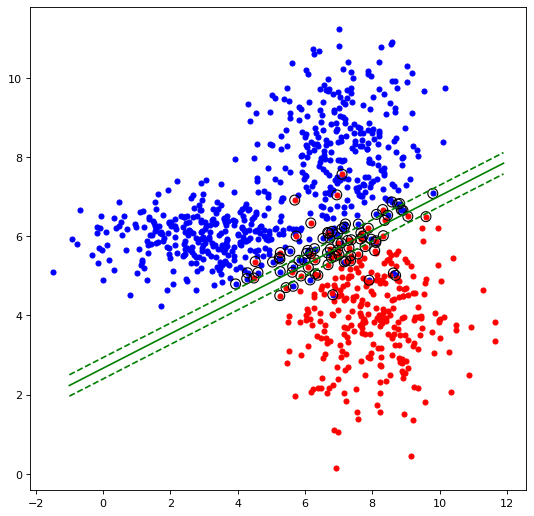

In [4]:
from sklearn import svm
mySVC = svm.SVC(kernel='linear', C=100)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')
plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, edgecolors='k', facecolors='none');

<div class="alert alert-warning">
    
**Exercice**<br>
Try different values for $C$ in the code above to see how the margin's boundaries evolve.
</div>

Remark: since the optimization problem behind SVMs requires the knowledge of the full dataset, SVMs are necessarily an offline method.

Let's plot how the number of support vectors change with $C$.

Recall, there are 600 blue points and 300 red points.
Training at C = 0.0001
Training at C = 0.001
Training at C = 0.01
Training at C = 0.1
Training at C = 1.0
Training at C = 10.0
Training at C = 100.0
Training at C = 1000.0
Training at C = 10000.0
Training at C = 100000.0
Training at C = 1000000.0


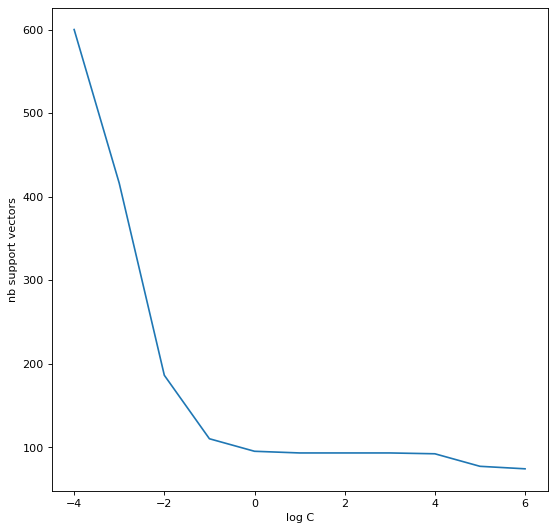

In [18]:
print("Recall, there are", Xblue.shape[0], "blue points and", Xred.shape[0], "red points.")
logC = np.arange(-4,7,1)
nbSV = np.zeros(len(logC))
for i in range(len(logC)):
    print("Training at C =", 10.**logC[i])
    mySVC = svm.SVC(kernel='linear', C=10.**logC[i])
    mySVC.fit(X,y)
    nbSV[i] = np.sum(mySVC.n_support_)

fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.plot(logC,nbSV)
plt.xlabel("log C")
plt.ylabel("nb support vectors");

Let's make a few predictions.

SV per class: [45 45]
w_i: [ 0.77342555 -1.76296957]
w_0: [4.62421327]
Margin: 0.519436801973221
w^T x0 + w_0: [-0.20112931]
w^T x1 + w_0: [-0.61573693]
w^T x2 + w_0: [-0.50354194]
(90, 2)
Prediction in [2 4] = -1
Prediction in [6 2] = 1
Prediction in [10  2] = 1
Training score:  0.9677777777777777


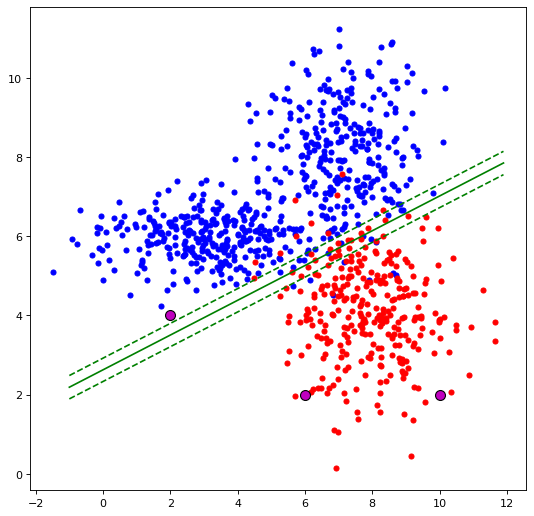

In [5]:
mySVC = svm.SVC(kernel='linear', C=1)
mySVC.fit(X,y)

# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)
print(mySVC.support_vectors_.shape)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
YY = -(w[0]*XX+w0+M)/w[1]
plt.plot(XX,YY,'g--')
YY = -(w[0]*XX+w0-M)/w[1]
plt.plot(XX,YY,'g--')

# Testing data
Xtest = np.array([[2,4],[6,2],[10,2]])
Ypred = mySVC.predict(Xtest)
for i in range(Xtest.shape[0]):
    print("Prediction in", Xtest[i,:], "=", Ypred[i])

plt.scatter(Xtest[:,0],Xtest[:,1], c='m', edgecolors="k", s=80);
print("Training score: ", mySVC.score(X,y))

# <a id="sec3"></a>3. When using linear separators makes no more sense

Let's take a look at the following data. Would it make sense to try to separate the red points from the blue ones with a straight line?

(400, 2)


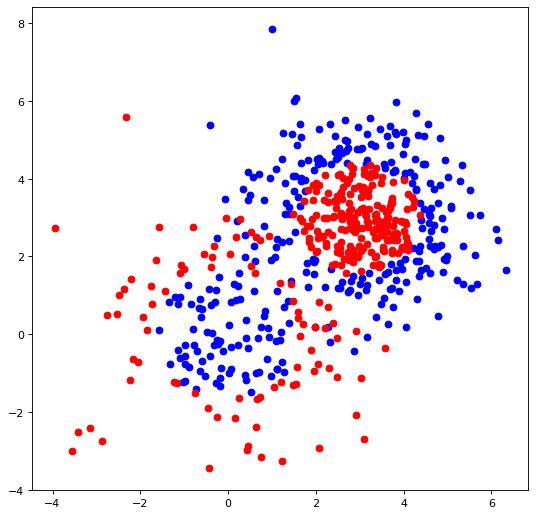

In [6]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.,
                                 n_samples=300, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = datasets.make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=700, n_features=2,
                                 n_classes=2, random_state=1)
#print(y1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y = 2*y-1

X, y = shuffle(X, y)

Xtest,X = np.split(X,[400])
ytest,y = np.split(y,[400])
print(Xtest.shape)

Xblue = X[y==-1]
Xred = X[y==1]
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
plt.scatter(Xred[:,0],Xred[:,1],c='r');
#?datasets.make_gaussian_quantiles

It does not look like a linear separation even makes sense. But let's try nonetheless, some optimal separating hyperplane must exist (even if it does not have great generalization properties).

<div class="alert alert-warning">
    
**Exercice:**<br>
Use scikit-learn to compute a linear Support Vector Classifier for the data above. Compute the classification score and conclude on the limits of this approach.
</div>

w =  [ 0.00740032 -0.22492317]
norm(w) =  0.22504487856174768
w0 =  [0.35364687]
Training score =  0.38
misclassification =  594


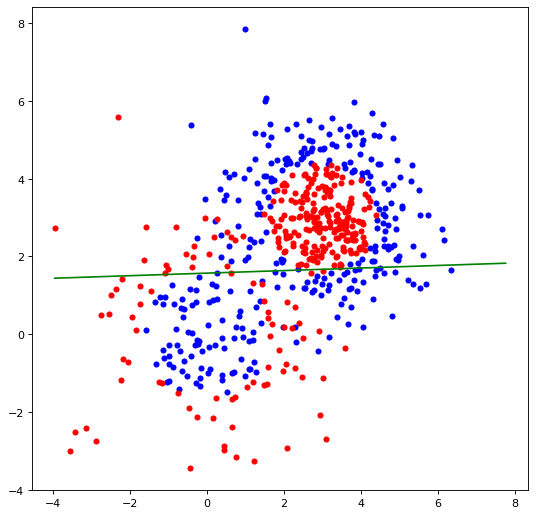

In [8]:
from sklearn import svm
mySVC = svm.SVC(kernel='linear', C = 1)
mySVC.fit(X,y)

w = mySVC.coef_[0]
w0 = mySVC.intercept_

print('w = ',w)
print('norm(w) = ', np.linalg.norm(w))
print('w0 = ',w0)

fig = plt.figure(figsize=fig_size, dpi=80, facecolor ='w',edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],color='b',s = 20)
plt.scatter(Xred[:,0],Xred[:,1],color='r',s = 20)
XX=np.arange(np.min(X[:,0]),np.max(X[:,1]),0.1)
YY = -(w[0]*XX + w0)/w[1]
plt.plot(XX,YY,color = 'g')
print('Training score = ', mySVC.score(X,y))
print('misclassification = ', np.sum(mySVC.n_support_))
#help(mySVC.score)

SV per class: [297 297]
w_i: [ 0.00740032 -0.22492317]
w_0: [0.35364687]
Margin: 4.443558131120147
w^T x0 + w_0: [-0.79491357]
w^T x1 + w_0: [0.24610804]
w^T x2 + w_0: [0.08579311]
Training score: 0.38


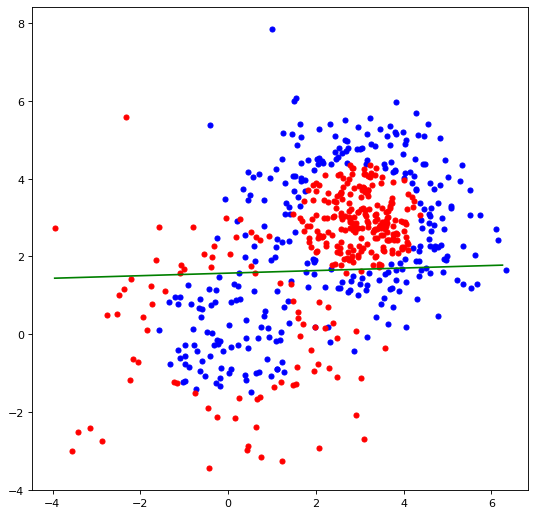

In [9]:
# %load solutions/code3.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

mySVC = svm.SVC(kernel='linear', C=1)
mySVC.fit(X,y)


# Compute margin and find support vectors
w = mySVC.coef_[0]
w0 = mySVC.intercept_
M = 1./np.linalg.norm(w)
print("SV per class:", mySVC.n_support_)
print("w_i:", w)
print("w_0:", w0)
print("Margin:", M)
print("w^T x0 + w_0:", np.dot(w,mySVC.support_vectors_[0,:])+w0)
print("w^T x1 + w_0:", np.dot(w,mySVC.support_vectors_[1,:])+w0)
print("w^T x2 + w_0:", np.dot(w,mySVC.support_vectors_[2,:])+w0)

# Plot the separating plane, the margin and the Support Vectors
fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xblue[:,0],Xblue[:,1],c='b',s=20)
plt.scatter(Xred[:,0],Xred[:,1],c='r',s=20)
XX = np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1)
#XX = np.arange(-1.,12.,0.1)
YY = -(w[0]*XX+w0)/w[1]
plt.plot(XX,YY,'g')
#YY = -(w[0]*XX+w0+M)/w[1]
#plt.plot(XX,YY,'g--')
#YY = -(w[0]*XX+w0-M)/w[1]
#plt.plot(XX,YY,'g--');
#plt.ylim(-6,10);
#plt.scatter(mySVC.support_vectors_[:,0], mySVC.support_vectors_[:,1], s=80, edgecolors='k', facecolors='none');
print("Training score:", mySVC.score(X,y))


Quite unconvincing, isn't it?

**A short metaphor before we go into more details**

<img src="img/crumpled-paper.jpg" width="400px"></img>

Take two blank sheets of paper. On the first one, draw a set of blue points. On the second, draw some red points. Now put one page on top of the other and crumple them together. The red and blue points are separable (whatever number of points there were on each sheet) , it's a certainty, since you put them on purpose on two different pieces of paper (two classes). But if you're given the current coordinates of each point, then building a relevant classifier might not be so easy. Some ideas follow from this intuition:
- Good classification might be feasible if we could build an inverse transformation ("uncrumpling") of the data that makes it linearly separable.
- Good classification functions should be able to approximate a large variety of geometric transformations of the data (this inverse transformation should be able to capture a large variety of of crumpling patterns).
- A classification method that can only approximate a few geometrical transformations is prone to miss the structure of the data. We call that *underfitting*, which is due to *high bias* in the family of classification functions.
- Having a large set of uncrumpling patterns (being able to approximate many geometrical transformations of the data) comes at the price of taking the risk of picking the wrong uncrumpling pattern given the finite amount of data at our disposal. We call that *overfitting*, which is due to *high variance* in the family of classification functions.

# <a id="sec4"></a>4. A word on the bias-variance tradeoff

The previous example is unconvincing mainly because we stubbornly look for a separator that has the shape of a straight line. Maybe if we allowed more flexibility, we could get better separators?

This compromise between flexibility and prior knowledge is called the **bias-variance** tradeoff in Machine Learning.
- If I search for a function that fits my data within a very restricted set of functions, I introduce a lot of expert knowledge, and thus a lot of **bias**, only allowing for little **variance** in the functions I might find.
- On the other hand, if I use a very rich family of functions, I abandon the introduction of prior information, allowing for high **variance** and low **bias**.

Although appealing, having high variance is not necessarily a good thing: looking for a function in a set that is just too rich leads to the risk of finding several almost equivalent functions that have great statistical properties but no physical meaning.

By maximizing the margin, SVMs actually try to minimize the variance of the family of functions considered: that is a way of trying to find the "simplest" function possible by minimizing $\|w\|$. This process is called **regularization** in Machine Learning. SVMs perform an $L_2$ regularization, but other forms of regularization exist and are commonly being used (e.g. $L_1$ regularization).

The bias-variance tradeoff captures the problem of **overfitting** (due to high variance) versus **underfitting** (due to high bias). Let's try to capture this formally. Assume a supervized learning task where one has data $y = f(x) + \epsilon$, where $f$ is a deterministic function and $\epsilon$ is a zero-mean noise with variance $\sigma^2$. The mean square generalization error of a prediction function $\hat{f}$ is:
$$err =  \mathbb{E}_x\left( \mathbb{E}_{y\sim f(x)+\epsilon} \left( \left( y - \hat{f}(x)\right)^2 \right) \right) = \mathbb{E} _x \left( err(x) \right)$$
with:
$$err(x) = \mathbb{E}_{y\sim f(x)+\epsilon} \left( \left( y - \hat{f}(x)\right)^2 \right)$$

Let's write $\mathbb{E}=\mathbb{E}_{y\sim f(x)+\epsilon}$, $f=f(x)$ and $\hat{f} = \hat{f}(x)$ for simplicity.

We have then:
\begin{align}
err(x) & = \mathbb{E} \left[ y^2 + \hat{f}^2 - 2y\hat{f} \right]\\
    & = \mathbb{E} \left[y^2\right] + \mathbb{E}\left[ \hat{f}^2\right] -2 \mathbb{E}\left[y\hat{f} \right]
\end{align}
But, by definition of the variance:
- $\mathbb{E} \left[y^2\right] = Var\left(y\right) + \mathbb{E} \left[y\right]^2 = \sigma^2 + f^2$
- $\mathbb{E}\left[ \hat{f}^2\right] = Var\left(\hat{f}\right) + \mathbb{E} \left[\hat{f}\right]^2$
- and $f$ is deterministic so $\mathbb{E}\left[y\hat{f} \right] = f\mathbb{E}\left[\hat{f}\right]$.

So:
\begin{align}
err & = \sigma^2 + f^2 + Var(\hat{f}) + \mathbb{E}\left[\hat{f}\right]^2 - 2 f\mathbb{E}\left[\hat{f}\right]\\
    & = \sigma^2 + Var(\hat{f}) + \left(f^2 -2 f\mathbb{E}\left[\hat{f}\right] + \mathbb{E}\left[\hat{f}\right]^2 \right)\\
    & = \sigma^2 + Var(\hat{f}) + \left( f - \mathbb{E}\left[\hat{f}\right] \right)^2\\
    & = \textrm{Irreducible error} + \textrm{Variance} + \textrm{Bias}^2
\end{align}

Let's explain each of these terms:
- The irreducible error $\sigma^2$ is the noise term in the true relationship that cannot fundamentally be reduced by any  learning model.
- The bias $f(x) - \mathbb{E}\left[\hat{f}(x)\right]$ measures how far from $f$ the best fit of $\hat{f}$ is.
- The variance $\mathbb{E}\left[ \hat{f}^2\right] - \mathbb{E} \left[\hat{f}\right]^2$ of $\hat{f}$ measures how much $\hat{f}$ is able to move around its mean.

So, overall, our goal is to reduce both variance and bias to minimize the generalization error. But in a world with finite data and no information on the true shape of $f$, there is a compromise to make between minimizing the bias or the variance.

SVMs make this compromise through the $C$ parameter: small $C$ will give more importance to maximizing the margin, thus minimizing the variance (and conversely, large $C$ values will emphasize the data fitting term and thus will minimize the bias).

# <a id="sec5"></a>5. The kernel trick

## <a id="sec5-1"></a> 5.1 The intuition of mapping to higher dimensions

Let's get back to the idea of giving more flexibility to our separator, since hyperplanes did not convince us they could always do the job.

To get around this problem, let's first introduce an illustrative example. The data below come from a voltage test in electronics. They indicate if a component fails or not under a certain voltage ($U$).

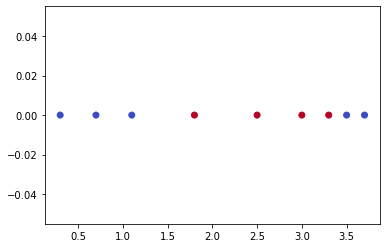

In [10]:
U = np.array([[0.3, 0.7, 1.1, 1.8, 2.5, 3.0, 3.3, 3.5, 3.7]]).T
Good = np.array( [[ -1,  -1,  -1,   1,   1,   1,   1,  -1,  -1]]).T
plt.figure()
plt.scatter(U, np.zeros((U.shape[0],1)), c=Good, cmap = plt.cm.coolwarm);

<div class="alert alert-warning">
    
**Question:**<br>Does it look like these data are linearly separable?</div>
<br>
Some well-experienced engineer already knows that $U$ is no good criterion to split the data points into two categories with a single threshold (recall: in dimension 1, a hyperplane is a threshold). He also knows that other indicators like $V = (U-2)^2$ are not any better, but that the pair $(U,V)$ actually allows to build a separating line between points.

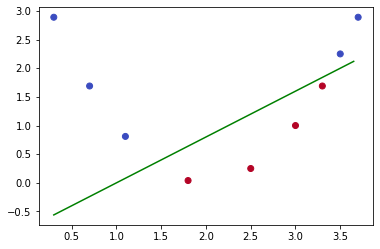

In [11]:
V = (2-U)**2
plt.figure()
plt.scatter(U, V, c=Good, cmap = plt.cm.coolwarm)
XX = np.arange(np.min(U), np.max(U), 0.05)
YY = -.8+.8*XX
plt.plot(XX,YY,'g');

Our nine points are now linearly separable. But we have not introduced any additional information!<br>
<br>
Actually, the only thing we have done, is to *map* our non-separable points $x$ into **another description space**, of higher dimension, where a linear separator exists.<br>

## <a id="sec5-2"></a> 5.2 The kernel trick

Suppose we happen to know such a relevant mapping for our data $\varphi(x)=x'$, where $\varphi$ maps to a $p$-dimensional Euclidean space ($p\gg n$, possibly infinite). Then we can compute the optimal linear separator in the corresponding higher dimension description space, find its parameters $w'$ and $w'_0$, and whenever we need to make a new prediction in a point $x$, we first compute its image $x'=\varphi(x)$ and then calculate $w'^T x' + w'_0$ to know on which side of the hyperplane we stand.

But recall that: $$w' = \sum_{i=1}^N \alpha_i y_i x'_i$$

So :
\begin{align*}
w'^T x' + w'_0 & = \left(\sum_{i=1}^N \alpha_i y_i x'_i\right)^T \varphi(x) + w_0\\
& = \sum_{i=1}^N \alpha_i y_i \varphi(x_i)^T \varphi(x) + w'_0
\end{align*}

Suppose that, instead of providing us with a mapping $\varphi(x)=x'$, somebody gave us a function $K(x_1, x_2)$ that takes two points $x_1$ and $x_2$, computes their respective images $\varphi(x_1)$ and $\varphi(x_2)$ and returns the dot product:
$$K(x_1,x_2)=\varphi(x_1)^T \varphi(x_2)$$

Then making predictions would boil down to:
$$w'^T x' + w'_0 = \sum_{i=1}^N \alpha_i y_i K(x_i,x) + w'_0$$

The interesting thing is that we don't need to compute $\varphi$ anymore. The function $K$ is known as a **kernel function** and that's what we call the **kernel trick**.

It is actually possible to compute the $\alpha_i$ and $w'_0$ just using $K$ and never $\varphi$, so, as long as somebody insures that **the kernel $K$ is a dot product in some other descriptor space** we can compute the optimal separating hyperplane of our data in this space, **without ever requiring a knowledge of this descriptor space and the mapping $\varphi$**.

## <a id="sec5-3"></a> 5.3 Positive definite kernels

The main question is thus: when can we guarantee that $K$ is an acceptable kernel? It is so if it is an inner product on a (separable) Hilbert space. So in more general words, we are interested in positive, definite kernels on a Hilbert space:

<div class="alert alert-success">
$K(\cdot,\cdot)$ is a positive definite kernel on $X$ if
$$\forall n\in\mathbb{N}, x\in X^n \text{ and } c\in \mathbb{R}^n, \ \sum\limits_{i,j=1}^n c_i c_j K(x_i,x_j) \geq 0$$
</div>

We will admit that Mercer's condition below is a sufficient condition for $K$ to be a positive definite kernel:
<div class="alert alert-success">
Given $K(x,y)$, if:
$$\forall g(x) / \int g(x)^2dx <\infty, \iint K(x,y)g(x)g(y)dxdy \geq 0$$
Then, there exists a mapping $h(\cdot)$ such that:
$$K(x,y) = \langle h(x), h(y) \rangle$$
</div>

There are many kernels that have been developped in the litterature. Combined with what we have seen before, it allows to build non-linear SVMs. The nice thing is that some kernels actually map our data to a descriptor space of infinite dimension, where it is presumably a lot easier to find a separating hyperplane.

One such kernel is the so-called "radial basis kernel" which is very popular and can be written:
$$K(x_1,x_2) = e^{-\gamma \|x_1-x_2\|^2}$$

Other common kernels:
- polynomial $K(x,y)=\left(1+\langle x, y\rangle\right)^d$
- sigmoid $K(x,y) = \tanh\left(\kappa_1 \langle x, y\rangle + \kappa_2\right)$

<div class="alert alert-warning">
    
**Exercice (off-class):**<br>
Check for yourself that the dual optimization problem for the SVM in the kernel's Hilbert space can be written:
$$\max\limits_{\alpha\in{\mathbb{R}^+}^N} L_D(\alpha) = \sum\limits_{i=1}^N \alpha_i - \frac{1}{2}\sum\limits_{i=1}^N\sum\limits_{j=1}^N \alpha_i \alpha_j y_i y_j K(x_i,x_j)$$
$$\text{such that } \sum\limits_{i=1}^N \alpha_i y_i = 0$$
$$\text{and } 0 \leq \alpha_i \leq C$$
So its resolution only requires the knowledge of $K$.
</div>

# <a id="sec6"></a>6. SVMs and kernels

Let's practice on the last dataset with a radial basis kernel.

SV per class: [142 140]


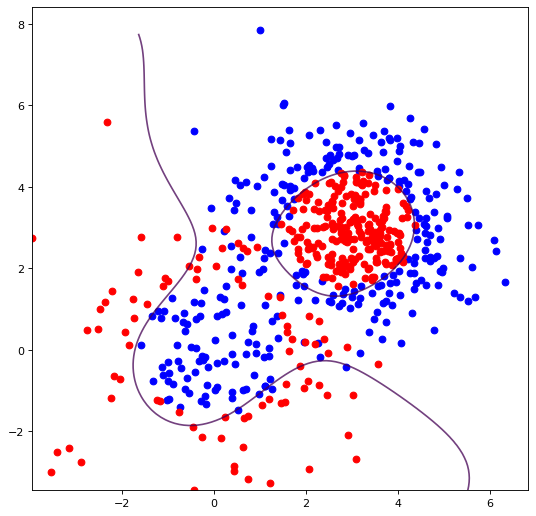

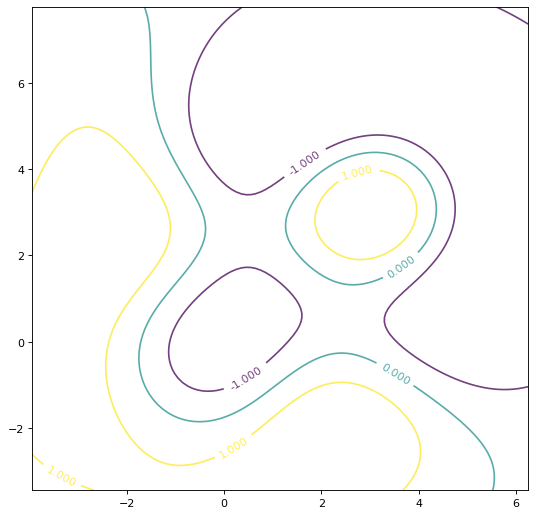

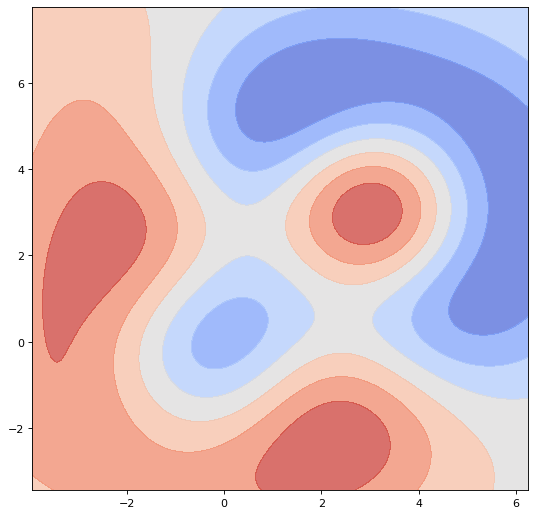

In [17]:
# Plot separator, margin and support vectors
def plot_SVC(mySVC):
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(Xblue[:,0],Xblue[:,1],c='b')
    plt.scatter(Xred[:,0],Xred[:,1],c='r')
    XX, YY = np.meshgrid(np.arange(np.min(X[:,0]),np.max(X[:,0]),0.1), np.arange(np.min(X[:,1]),np.max(X[:,1]),0.1))
    ZZ = mySVC.decision_function(np.c_[XX.ravel(), YY.ravel()])
    ZZ = ZZ.reshape(XX.shape)
    plt.contour(XX, YY, ZZ, levels=[0],alpha=0.75)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contour(XX, YY, ZZ, levels=[-1., 0., 1.], alpha=0.75)
    plt.clabel(cont, cont.levels, inline=True, fontsize=10)#, cmap = plt.cm.coolwarm)
    fig=plt.figure(figsize=fig_size, dpi= 80, facecolor='w', edgecolor='k')
    cont = plt.contourf(XX, YY, ZZ, alpha=0.75, cmap = plt.cm.coolwarm)

# We can play with C
mySVC = svm.SVC(kernel='rbf', C=1.)
mySVC.fit(X,y)

print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC)

A lot better isn't it? Let's play a little with the value of $C$.

<div class="alert alert-warning">
    
**Exercice:**<br>
Let's see how that SVM with the rbf kernel would do on the data from the beginning of this notebook.
</div>

SV per class: [9 7]


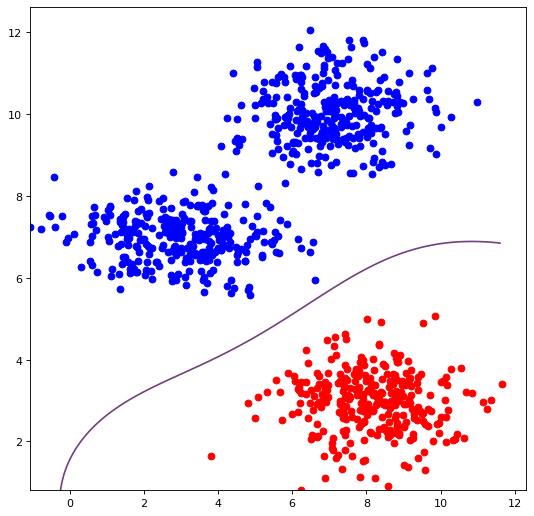

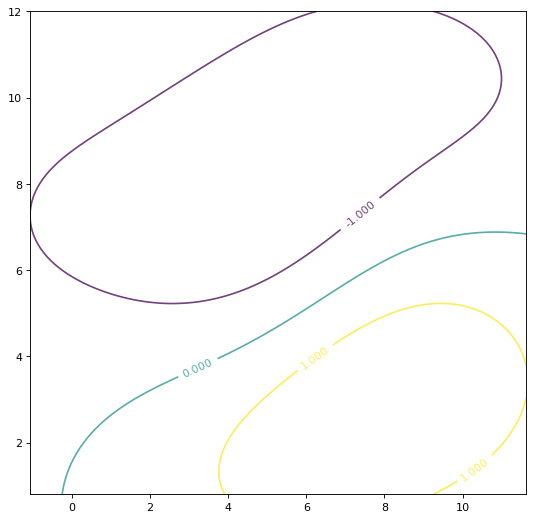

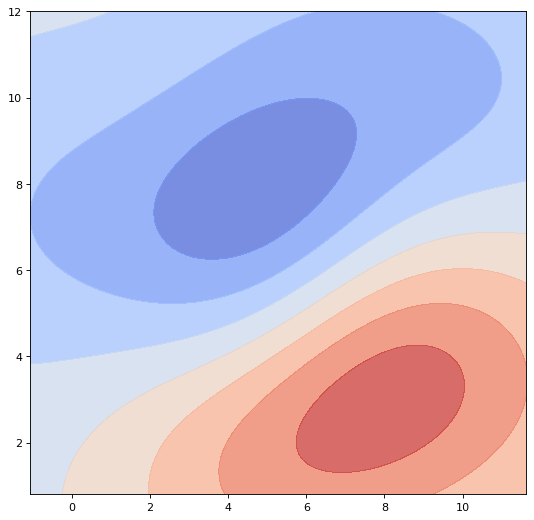

In [19]:
# %load solutions/code4.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

res = np.loadtxt("sep_lin.csv", delimiter=',')
X = res[:,0:-1]
y = res[:,-1].astype(int)
Xblue = X[y==-1]
Xred = X[y==1]

mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)
print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC);


<div class="alert alert-warning">
    
**Exercice:**<br>
And on the "linearly separable + noise" case?
</div>

SV per class: [49 48]


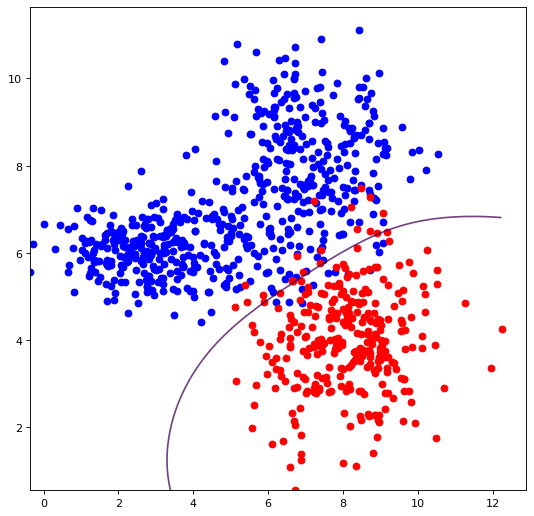

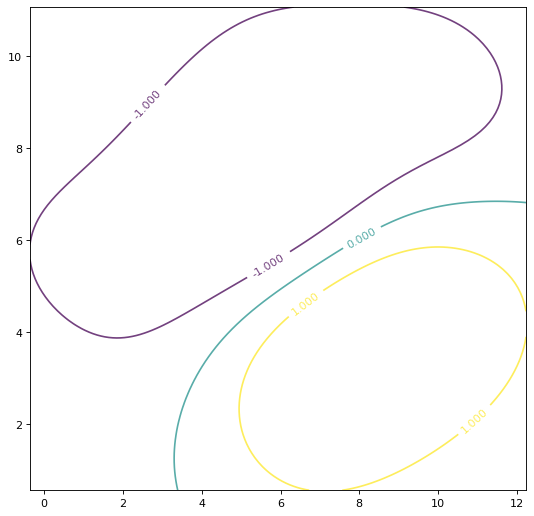

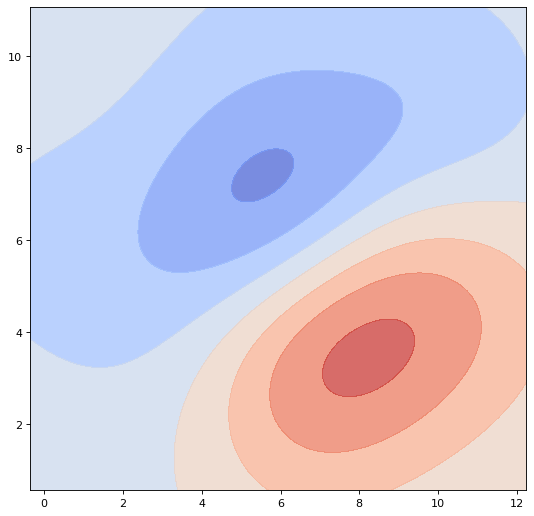

In [20]:
X1, y1 = datasets.make_gaussian_quantiles(cov=2.0, n_samples=300, n_features=2, n_classes=1)
X1[:,0] = 3. + X1[:,0]
X1[:,1] = 6. + X1[:,1]/2.5
X2, y2 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X2[:,0] = 8. + X2[:,0]
X2[:,1] = 4. + X2[:,1]
X3, y3 = datasets.make_gaussian_quantiles(cov=1.5, n_samples=300, n_features=2, n_classes=1)
X3[:,0] = 7. + X3[:,0]
X3[:,1] = 8. + X3[:,1]
X = np.concatenate((X1, X2, X3))
y = np.concatenate((y1, - y2 + 1, y3))
y = 2*y-1
X, y = shuffle(X, y)
Xblue = X[y==-1]
Xred = X[y==1]

# Display
mySVC = svm.SVC(kernel='rbf')
mySVC.fit(X,y)
print("SV per class:", mySVC.n_support_)
plot_SVC(mySVC);

These two last experiments illustrate that introducing complex kernels such as the rbf one is sometimes detrimental.

# <a id="sec7"></a>7. What about other uses?

SVMs can also be used to solve regression problems, although they are not often used for that in practice. The optimization problem differs a little but the main ideas remain. In scikit-learn, they can be accessed by using the `svm.SVR` class.

In the regression case, we do not want to separate anymore but to *fit* the hyperplane to the data. For this purpose, we define a *loss function* $\sum_i V(y_i - f(x_i))$ and the objective function becomes:
$$\min\limits_{w, w_0} \frac{1}{2} \|w\|^2 + C \sum\limits_{i=1}^N V(y_i-w^T x_i + w_0))$$

Usual loss functions:
- $\epsilon$-insensitive, $V(z) = \left\{\begin{array}{l} 0\text{ if }|z|\leq\epsilon\\ |z|-\epsilon\text{ otherwise}\end{array}\right.$
- Laplacian, $V(z) = |z|$
- Gaussian, $V(z) = \frac{1}{2}z^2$
- Huber's robust loss, $V(z) = \left\{\begin{array}{l}\frac{1}{2\sigma}z^2\text{ if }|z|\leq\sigma \\ |z|-\frac{\sigma}{2}\text{ otherwise}\end{array}\right.$


The $\epsilon$-insensitive loss:
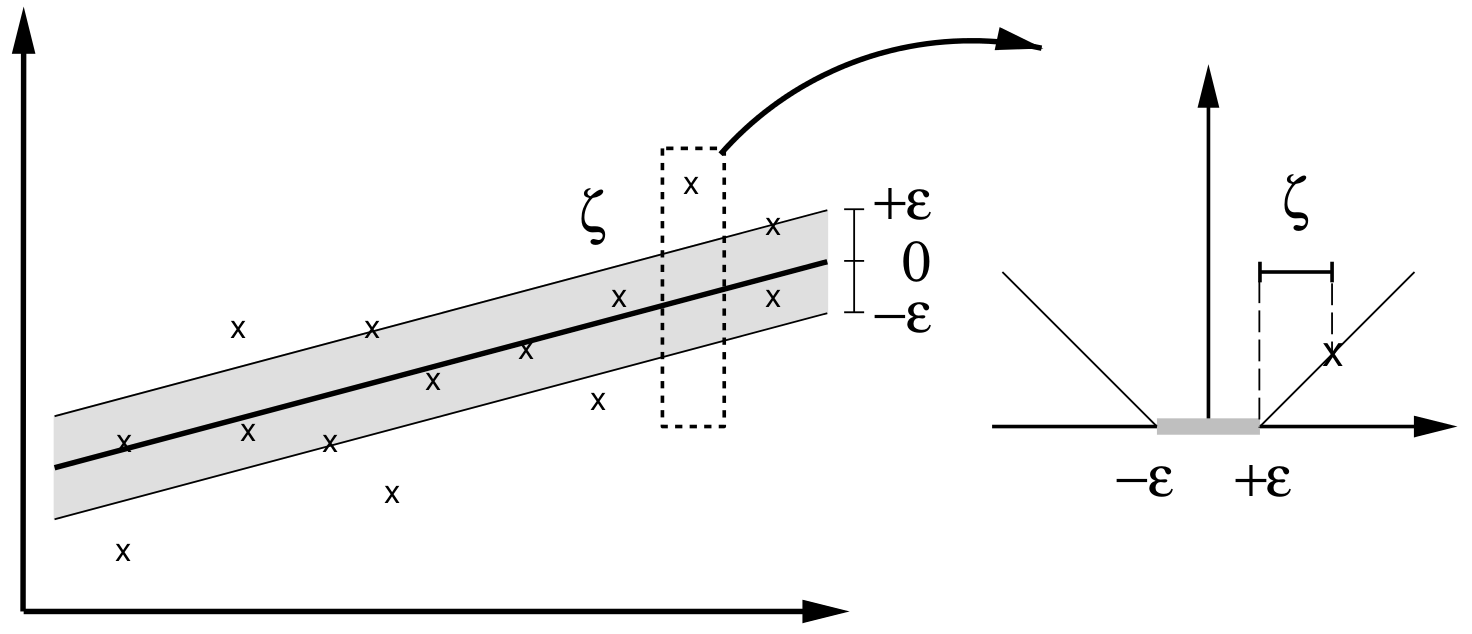</img>

The optimization problem and its resolution are quite similar to the classification case (but a little heavier, notation-wise) and left to your curiosity.

Similarly, one can derive a formulation of SVMs for density estimation by using *One-Class SVMs*.

SVMs easily support class weights and sample weights and can deal with unbalanced problems.

The general description of [SVMs in scikit-learn](http://scikit-learn.org/stable/modules/svm.html) is a good reminder on the versatility and the limitations of SVMs.

<div class="alert alert-success">
    
**In a nutshell:**
<ul>
<li> Support Vector Machines for classification try to separate data by maximizing a geometrical margin
<li> They are computed offline
<li> They offer a sparse, robust to class imbalance, and easy to evaluate predictor
<li> Kernels are a way of enriching (lifting) the data representation so that it becomes linearly separable
<li> SVMs + kernels offer a versatile method for classification, regression and density estimation
<li> [Documentation in scikit-learn](http://scikit-learn.org/stable/modules/svm.html)
</ul>
</div>

Good references:<br>
**A tutorial on Support Vector Machines for Pattern Recognition.**<br>
C. J. C. Burges, *Data Mining and Knowledge Discovery*, **2**, 131-167, (1998).<br>

**A tutorial on Support Vector Regression.**<br>
A. J. Smola and B. Schölkopf, *Journal of Statistics and Computing*, **14**(3), 199-222, (2004).

# <a id="sec8"></a>8. Examples

## <a id="sec8-1"></a>8.1 Spam or ham?

<div class="alert alert-warning">
    
**Exercice:**<br>
Your turn to play: let's build a spam classifier using the ling-spam dataset and a linear SVM. Compute it's score on the validation dataset below.
</div>

In [21]:
from sys import path
path.append('../2 - Text data preprocessing')
import load_spam
spam_data = load_spam.spam_data_loader()
spam_data.load_data()

Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)

In [28]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)

(2000, 14279)
(893, 14279)
(2000,)


In [24]:
# %load solutions/code5.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain);

print("score:", spam_svc.score(Xtest,ytest))

# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000)
    spam_svc = svm.SVC(kernel='linear', C=1.)
    spam_svc.fit(Xtrain,ytrain);
    score += [spam_svc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))


score: 0.986562150055991
******************** done!
Average generalization score: 0.9902015677491601
Standard deviation: 0.002917450273261601


<div class="alert alert-warning">
    
**Exercice:**<br>
We've trained our model in the Tf-Idf data. Let's see how the model behaves on raw word counts.
</div>

In [34]:
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000, feat='wordcount')
?spam_data.split

Signature: spam_data.split(n, feat='tfidf')
Docstring: <no docstring>
File:      c:\users\32474\documents\supaero\s5\filière\aml\jonathan sprauel\mlclass\2 - text data preprocessing\load_spam.py
Type:      method


In [35]:
# %load solutions/code6.py
### WRITE YOUR CODE HERE
# If you get stuck, uncomment the line above to load a correction in this cell (then you can execute this code).

spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain)
print("Score:", spam_svc.score(Xtest,ytest))

# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = spam_data.shuffle_and_split(2000, feat='wordcount')
    spam_svc = svm.SVC(kernel='linear', C=1.)
    spam_svc.fit(Xtrain,ytrain);
    score += [spam_svc.score(Xtest,ytest)]
    print('*', end='')
print(" done!")

print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))



Score: 0.9798432250839866
******************** done!
Average generalization score: 0.9860022396416573
Standard deviation: 0.0036886156980964323


<div class="alert alert-warning">
    
**Exercice:** Want to try another kernel than linear?</div>

Let's keep the tf-idf with linear SVM classifier (which seems to work better) and use it to identify which are the misclassified emails (and find the confusion matrix by the way).

In [36]:
# Retrain
Xtrain, ytrain, Xtest, ytest = spam_data.split(2000)
spam_svc = svm.SVC(kernel='linear', C=1.)
spam_svc.fit(Xtrain,ytrain);

In [38]:
# Find misclassified examples
ypredict = spam_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
#print(misclass)
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
misclass_indices = [i for i, j in enumerate(misclass) if j == True]
print("Misclassified messages indices:", misclass_indices)

Misclassified messages indices: [15, 24, 273, 283, 293, 303, 309, 471, 579, 584, 601, 869]


In [39]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[722   1]
 [ 11 159]]


In [42]:
# Check some misclassified mails
index = misclass_indices[0]+2000
print("Prediction:", spam_svc.predict(spam_data.tfidf[index,:]))
spam_data.print_email(index)

Prediction: [False]
email file: ../data/lingspam_public/bare/part6\spmsgb48.txt
email is a spam: True
Subject: microsynergy cd - r specials edition 10

microsynergy cd - r specials edition ( 10 ) to be removed from this mailing list , simply hit reply and type " remove " in the subject line . thank you , xceed communications . * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * microsynergy is an industry-leading manufacturer of vertically integrated systems that employ key optical peripherals and adapters such as : cd duplication systems cd-rom servers cd jukeboxes cd towers * * * note : to receive special pricing from this promotion , be sure to mention " cd - r specials edition ( 10 ) " or type it into the comment field on the online order form . thank you . idt / microsynergy is pleased to extend the following specials , ms - 5 cd duplication system . standalone duplication system with five 4x writers records up to 20 cd

## <a id="sec8-2"></a>8.2. NIST

Let's evaluate SVMs on the optical character recognition task of the NIST data.

(1797, 64)
(1797, 8, 8)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


<Figure size 432x288 with 0 Axes>

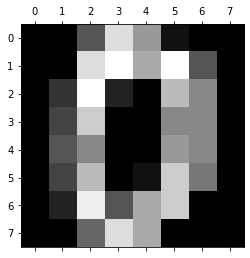

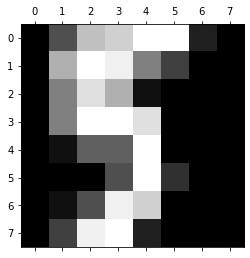

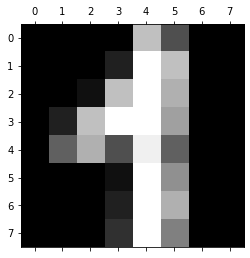

In [44]:
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt

digits = datasets.load_digits()
print(digits.data.shape)
print(digits.images.shape)
print(digits.target.shape)
print(digits.target_names)

X = digits.data
y = digits.target
Xtrain,Xtest = np.split(X,[1000])
ytrain,ytest = np.split(y,[1000])
#Xtrain = X[:1000,:]
#ytrain = y[:1000]
#Xtest = X[1000:,:]
#ytest = y[1000:]

#print(digits.DESCR)

plt.gray();
plt.matshow(digits.images[0]);
plt.show();
plt.matshow(digits.images[15]);
plt.show();
plt.matshow(digits.images[42]);
plt.show();

In [45]:
from sklearn.utils import shuffle

def shuffle_and_split(X,y,n):
    X0,y0 = shuffle(X,y)
    Xtrain,Xtest = np.split(X0,[n])
    ytrain,ytest = np.split(y0,[n])
    return Xtrain, ytrain, Xtest, ytest

In [47]:
print(Xtrain.shape)
print(ytrain.shape)
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain)
prediction = digits_svc.predict(Xtest)
#print("Training error:", np.sum(np.not_equal(prediction,ytest))/len(ytest))
print("Generalization error:", np.sum(np.not_equal(prediction,ytest))/len(ytest) )
print("Generalization score:", digits_svc.score(Xtest,ytest))

(1000, 64)
(1000,)
Training error: 0.030112923462986198
Generalization error: 0.030112923462986198
Generalization score: 0.9698870765370138


In [48]:
# Compute cross-validation score
nb_trials = 20
score = []
for i in range(nb_trials):
    Xtrain, ytrain, Xtest, ytest = shuffle_and_split(X,y,1000)
    digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
    digits_svc.fit(Xtrain,ytrain)
    score += [digits_svc.score(Xtest,ytest)]
    print('*',end='')
print(" done!")

******************** done!


In [49]:
print("Average generalization score:", np.mean(score))
print("Standard deviation:", np.std(score))

Average generalization score: 0.9878293601003764
Standard deviation: 0.002918369723867755


Let's identify which are the misclassified images (and find the confusion matrix by the way).

In [50]:
# Retrain
Xtrain = X[:1000,:]
ytrain = y[:1000]
Xtest = X[1000:,:]
ytest = y[1000:]
digits_svc = svm.SVC(kernel='rbf', gamma=1e-3)
digits_svc.fit(Xtrain,ytrain);

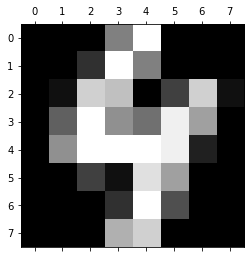

prediction on image number 1053 : [4]
correct label                : 4


In [51]:
# Examples
N = 1053
plt.matshow(digits.images[N]) 
plt.show() 
x = digits.data[N,:]
print("prediction on image number", N, ":", digits_svc.predict([digits.data[N,:]]))
print("correct label                :", digits.target[N])

In [52]:
# Find misclassified examples
ypredict = digits_svc.predict(Xtest)
misclass = np.not_equal(ypredict, ytest)
Itest = digits.images[1000:,:]
Xmisclass = Xtest[misclass,:]
ymisclass = ytest[misclass]
Imisclass = Itest[misclass,:]

In [53]:
print("Confusion matrix:")
print(confusion_matrix(ytest, ypredict))

Confusion matrix:
[[78  0  0  0  1  0  0  0  0  0]
 [ 0 77  1  0  0  0  0  0  1  1]
 [ 0  0 76  1  0  0  0  0  0  0]
 [ 0  0  0 68  0  3  0  4  4  0]
 [ 0  0  0  0 79  0  0  0  0  4]
 [ 0  0  0  0  0 81  1  0  0  0]
 [ 0  1  0  0  0  0 79  0  0  0]
 [ 0  0  0  0  0  0  0 80  0  0]
 [ 0  0  0  0  0  0  0  0 76  0]
 [ 0  0  0  1  0  1  0  0  0 79]]


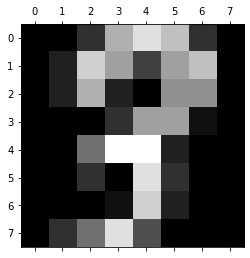

prediction on image number 1 : [7]
correct label                : 3


In [54]:
# Display misclassified examples
N = 1
plt.matshow(Imisclass[N]) 
plt.show() 
print("prediction on image number", N, ":", digits_svc.predict([Xmisclass[N,:]]))
print("correct label                :", ymisclass[N])